In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

numpy   1.18.4
pandas  1.0.4
seaborn 0.10.1



In [2]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5037974/
inf_truth = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/mbarc_26/SRR3656745/mbarc_26_truth.txt"
inf_tax_file = "/mnt/btrfs/data/rep202/ab/taxmap.tsv"
outf_truth = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/mbarc_26/SRR3656745/mbarc_26_truth_rg.txt"

inf_coverage = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/mbarc_26/SRR3656745/filter/coverage-201029.txt"

In [3]:
with open(outf_truth, "w") as outf:
    with open(inf_truth) as inf:
        for query in inf:
            query = query.rstrip()
            print(query)
            results = !rg {query} {inf_tax_file}
            for result in results:
                outf.write(result + "\n")

Muricauda
Thioclava
Cohaesibacter
Propionibacteriaceae
Marinobacter
Marinobacter
Psychrobacter
Micromonospora_echinaurantiaca
Micromonospora_echinofusca
Micromonospora_coxensis
Halomonas
Halomonas


In [4]:
df_inf_coverage = pd.read_csv(inf_coverage, sep="\t")
headers = list(df_inf_coverage.columns)
headers[0] = "tax"
df_inf_coverage.columns = headers

In [5]:
df_inf_coverage["hits_in_clade"].median()

7.0

In [19]:
df_truth = pd.read_csv(outf_truth, header=None, sep="\t")

df_truth.columns = ["id", "tax"]
df_truth["species"] = [";".join(s.split(";")[:7]) for s in df_truth["tax"]]
s_truth = set(df_truth["species"])
df_inf_coverage["truth"] = [species in s_truth for species in df_inf_coverage.tax]
df_inf_coverage["truth"].sum()
len(s_truth)

225

In [22]:
# print the species not in mock
s_inf = set(df_inf_coverage.loc[df_inf_coverage["truth"], "tax"])
s_truth.difference(s_inf)

{'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Acidipropionibacterium;s__Acidipropionibacterium_timonense',
 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Cutibacterium;s__Cutibacterium_avidum',
 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Cutibacterium;s__[Propionibacterium]_namnetense',
 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Desertihabitans;s__Desertihabitans_aurantiacus',
 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Desertihabitans;s__Desertihabitans_brevis',
 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Luteococcus;s__Luteococcus_japonicus',
 'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteriaceae;g__Microlunatus;s__M

In [23]:
# we might want to drop all viruses and plasmids for this analysis

mask_plasmids = df_inf_coverage["tax"].apply(lambda x: "plasmid" in x.lower())
mask_virus = df_inf_coverage["tax"].apply(lambda x: "virus" in x.lower())

df_masked = df_inf_coverage.loc[(~(mask_plasmids | mask_virus))].copy()

In [24]:
df_masked[df_masked["truth"]]

,tax,max_uncovered_region,percent_max_uncovered_region,percent_of_genome_covered,median_genome_size,hits_in_clade,unique_counts_of_clade,expected_coverage,ratio_covered_over_expected,truth
89,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,34271.0,0.40564,0.00267,84487.0,3992.0,68582.0,0.05655,0.04731,True
94,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,11946.0,0.14225,0.85759,83978.0,697174.0,72560.0,0.99993,0.85765,True
95,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,17219.0,0.19736,0.80262,87246.0,840152.0,71103.0,0.99999,0.80262,True
189,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,26299.0,0.66578,0.00020,39501.0,4.0,37551.0,0.00011,1.90134,True
190,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,19784.0,0.58055,0.00018,34078.0,3.0,31464.0,0.00010,1.84665,True
...,...,...,...,...,...,...,...,...,...,...
2259,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,19470.0,0.54393,0.00156,35795.0,9968.0,30763.0,0.27677,0.00565,True
2260,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,15460.0,0.47342,0.00257,32656.0,10137.0,30306.0,0.28430,0.00905,True
2261,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,34767.0,0.99865,0.00089,34814.0,3429.0,34112.0,0.09564,0.00931,True
2262,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,21177.0,0.70517,0.00077,30031.0,4156.0,29107.0,0.13306,0.00576,True


In [25]:
df_masked.loc[df_masked["truth"], "percent_of_genome_covered"].mean()

0.019836048780487805

In [26]:
df_masked.loc[~df_masked["truth"], "percent_of_genome_covered"].mean()

0.0002201743264659271

In [27]:
df_masked.groupby("truth").mean()

,max_uncovered_region,percent_max_uncovered_region,percent_of_genome_covered,median_genome_size,hits_in_clade,unique_counts_of_clade,expected_coverage,ratio_covered_over_expected
truth,,,,,,,,
False,46629.255151,0.840382,0.000220,57676.131537,172.875198,46821.803487,0.003613,1.026879
True,25234.190244,0.602901,0.019836,42969.131707,30215.073171,40038.087805,0.205452,0.216797


In [29]:
import lightgbm

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [51]:
X = df_masked.loc[:, df_masked.columns.difference(["truth", "tax", "percent_max_uncovered_region", "ratio_covered_over_expected"])]
y = df_masked["truth"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#
# Create the LightGBM data containers
#
# categorical_features = [c for c, col in enumerate(train.columns) if 'cat' in col]
# train_data = lightgbm.Dataset(x, label=y, categorical_feature=categorical_features)
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)

In [52]:
#
# Train the model
#

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

lgb = lightgbm.LGBMClassifier(**parameters)
lgb.fit(X_train, y_train)

LGBMClassifier(application='binary', bagging_fraction=0.5, bagging_freq=20,
               boosting='gbdt', feature_fraction=0.5, is_unbalance='true',
               learning_rate=0.05, metric='auc', objective='binary', verbose=0)

In [ ]:
lgb.predict()

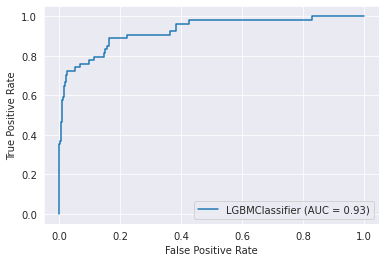

In [53]:
lgb_disp = plot_roc_curve(lgb, X_test, y_test)
plt.show()

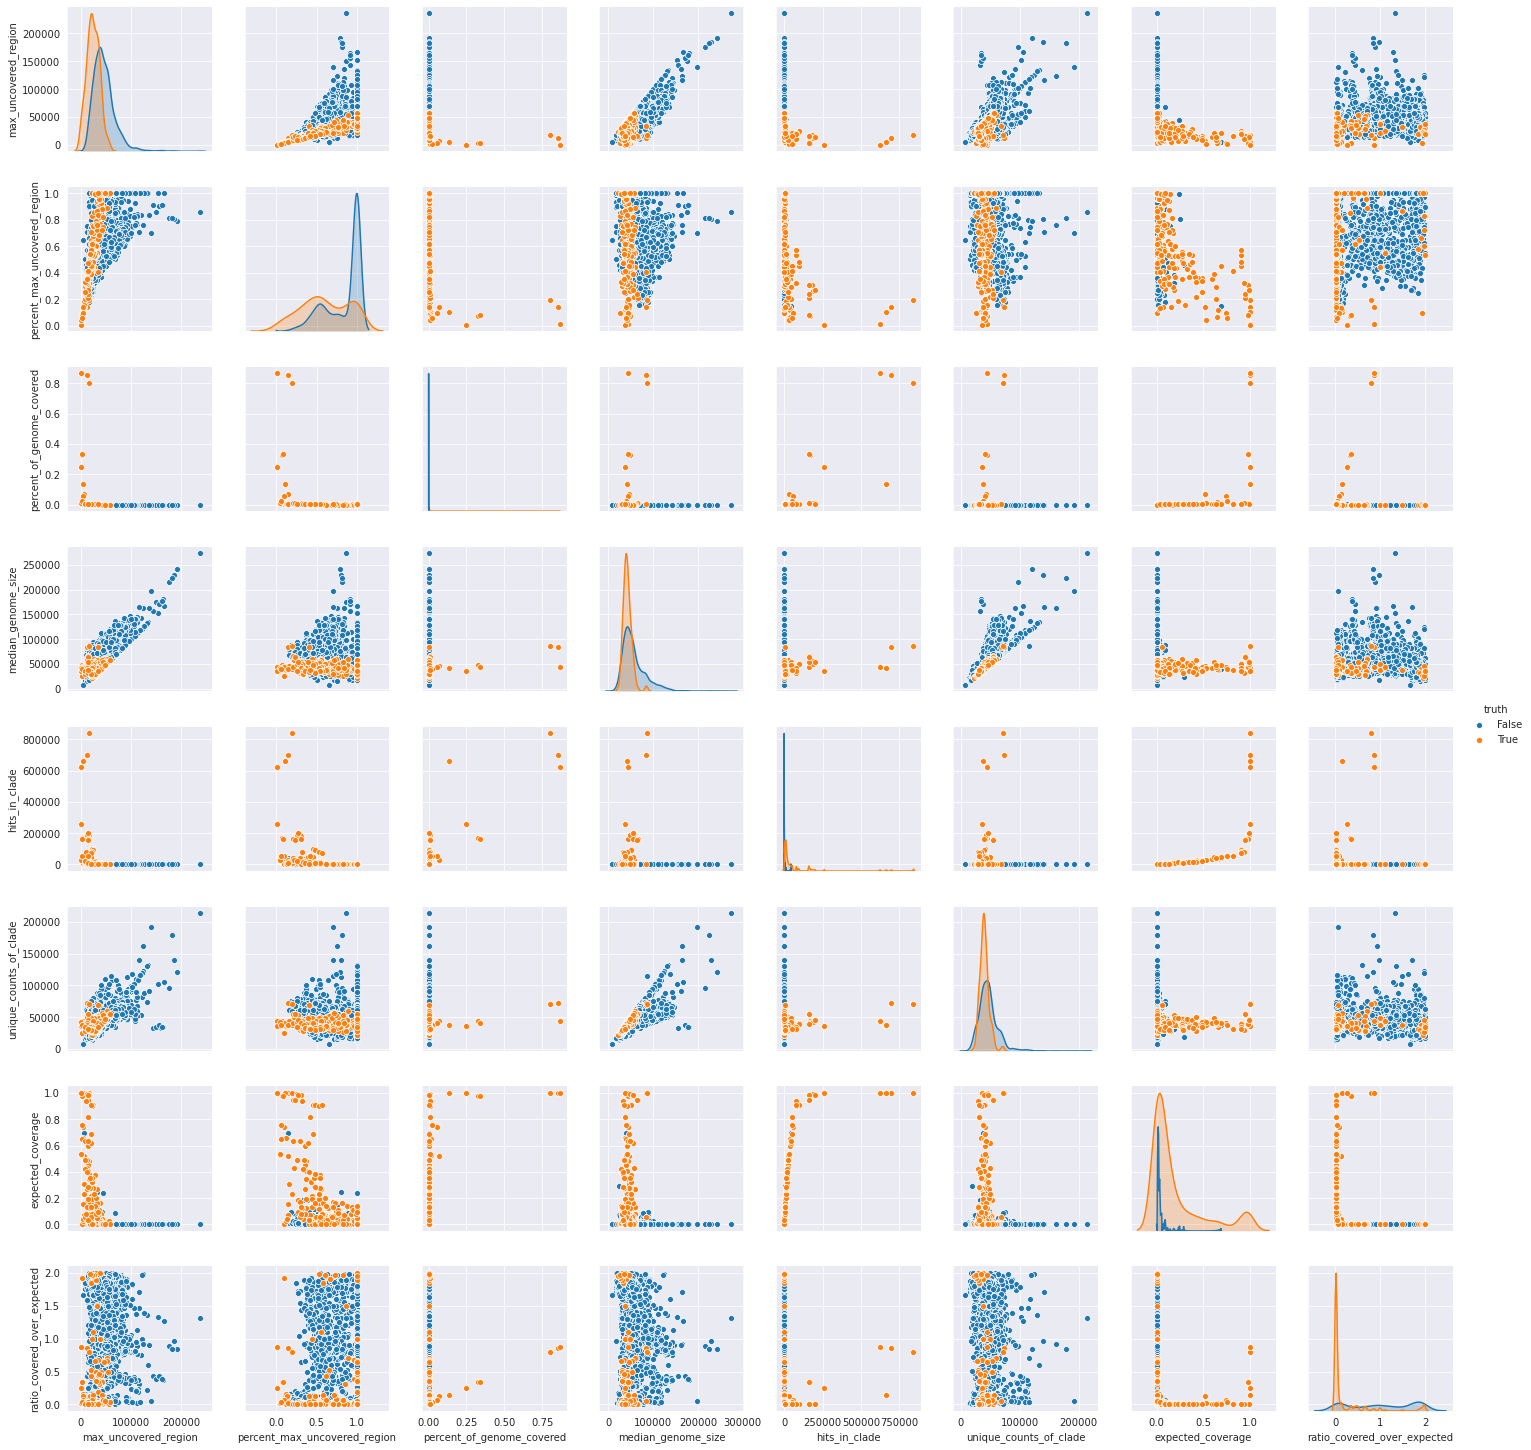

In [54]:
sns.pairplot(df_masked, hue="truth")

In [58]:
sum(lgb.predict(X))

231

In [40]:
X[lgb.predict_proba(X)[:, 1]  > .75]

array([0.99887709, 0.9937503 , 0.98650227, ..., 0.98002494, 0.99855629,
       0.95673205])

In [42]:
predictions = lgb.predict_proba(X)

In [45]:
predictions[:i]

TypeError: slice indices must be integers or None or have an __index__ method

In [47]:
df_masked.shape

(2729, 10)

In [60]:
df_masked.loc[predictions[:, 1] >= .5, ["tax", "truth"]].shape

(237, 2)

In [43]:
for i in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
    print(y[predictions[:, 1] > i].sum() / (predictions[:, 1] > i).sum())
print(df_masked.loc[predictions[:, 1] > .5, ["tax", "truth"]].values)

0.4314606741573034
0.5794392523364486
0.6678700361010831
0.7042801556420234
0.7510548523206751
0.7772727272727272
0.8059701492537313
0.8387096774193549
0.88125
[['k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micromonosporales;f__Micromonosporaceae;g__Micromonospora;s__Micromonospora_coxensis'
  True]
 ['k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micromonosporales;f__Micromonosporaceae;g__Micromonospora;s__Micromonospora_echinaurantiaca'
  True]
 ['k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micromonosporales;f__Micromonosporaceae;g__Micromonospora;s__Micromonospora_echinofusca'
  True]
 ['k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Micromonosporales;f__Micromonosporaceae;g__Salinispora;s__Salinispora_tropica'
  False]
 ['k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Nocardioidaceae;g__Propionicimonas;s__Propionicimonas_paludicola'
  False]
 ['k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Propionibacteriales;f__Propionibacteri